Performing Exploratory and data Preparation on the future house data and LSTM forecasting on household meterusage

In [1]:
#---------------------------------------Introduction to Data Preparation--------------------------------------------------

Created by John Omole Email: contact@johnomole.de Website: www.johnomole.de

In [2]:
#------------------------------------Importing Libraries needed.------------------------------------#

In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import os

In [4]:
# importing libraries required for our model
import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,Dropout
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

In [5]:
#------------------------------------Data Preparation.------------------------------------#

In [20]:
df = pd.read_csv('meterusage/meterusage.csv')

In [21]:
#Check for the first 5 data in the file
print('Meterusage Data')
display(df.head())

#stastical analysis of the training data
print('Meterusage Data Descriptive Statistic')
display(df.describe())

Meterusage Data


,time,meterusage
0,2019-01-01 00:15:00,55.09
1,2019-01-01 00:30:00,54.64
2,2019-01-01 00:45:00,55.18
3,2019-01-01 01:00:00,56.03
4,2019-01-01 01:15:00,55.77


Meterusage Data Descriptive Statistic


,meterusage
count,2974.000000
mean,143.091342
std,92.549512
min,45.600000
25%,55.682500
50%,117.615000
75%,253.057500
max,355.440000


In [22]:
#------------------------------------Data Cleaning.------------------------------------#

In [23]:
#  Checking for nan or empty number in the training data
print('Meterusage')
display(df.isnull().sum())

Meterusage


time          0
meterusage    1
dtype: int64

In [24]:
df.dropna(inplace = True)

In [25]:
print('Meterusage rows: ', df.shape[0])
print('Meterusage columns: ', df.shape[1])

Meterusage rows:  2974
Meterusage columns:  2


In [26]:
#Removing outliers

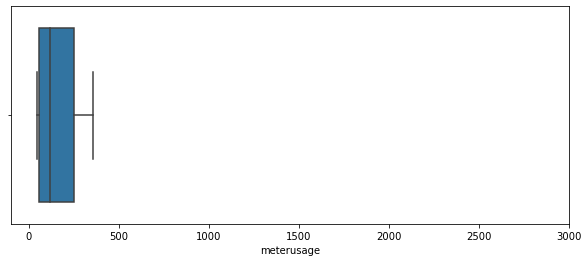

In [27]:
#Visualising outliers
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df.meterusage, flierprops=flierprops)

In [28]:
#Dropping Ouliers
def drop_out(df,feature,high_percentile = .99):
    df_shape = df.shape[0]         #train df size before dropping
    max_val = df[feature].quantile(high_percentile)      #Percentile value
    print('Dropping Outliers for ... {}'.format(feature))
    df = df[df[feature] < max_val]
    print(str(df_shape - df.shape[0]) + ' ' + feature + ' values over ' + str(max_val) + ' have been removed' )
    return df

In [29]:
#Dropping outliers for item_price
df = drop_out(df,'meterusage')

Dropping Outliers for ... meterusage
30 meterusage values over 295.5054 have been removed


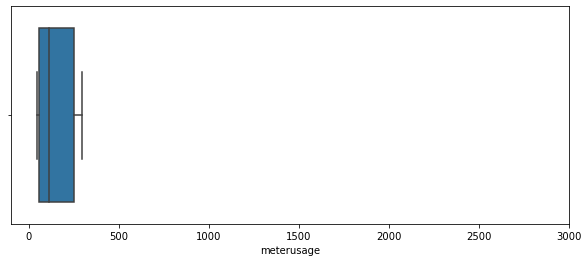

In [30]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=df.meterusage, flierprops=flierprops)

In [31]:
print('Meterusage')
display(df.head())

print('Shape')
display(df.shape)

print('Stats')
display(df.describe())


print('Data Information')
display(df.info())

Meterusage


,time,meterusage
0,2019-01-01 00:15:00,55.09
1,2019-01-01 00:30:00,54.64
2,2019-01-01 00:45:00,55.18
3,2019-01-01 01:00:00,56.03
4,2019-01-01 01:15:00,55.77


Shape


(2944, 2)

Stats


,meterusage
count,2944.000000
mean,141.457959
std,91.576480
min,45.600000
25%,55.645000
50%,113.545000
75%,250.505000
max,295.500000


Data Information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 2974
Data columns (total 2 columns):
time          2944 non-null object
meterusage    2944 non-null float64
dtypes: float64(1), object(1)
memory usage: 69.0+ KB


None

In [32]:
#We will need data for our LSTM and df for some cool plots
data = df

In [33]:
#------------------------------------Visualization.------------------------------------#

In [34]:
# Indexing time for the dataframe
df.index = df['time']
df=df.drop(['time'],axis=1)

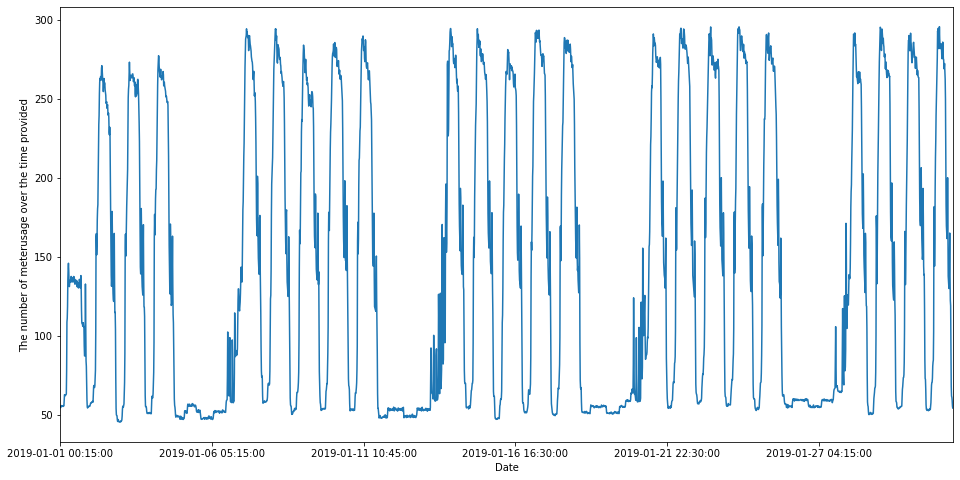

In [35]:
plt.figure(figsize=(16,8))
df['meterusage'].plot()
plt.xlabel('Date')
plt.ylabel('The number of meterusage over the time provided')
plt.show()

Data distribution


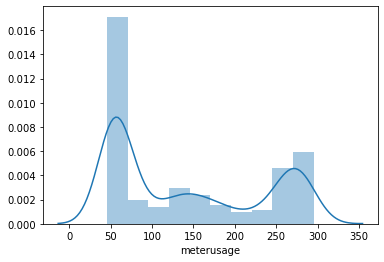

In [37]:
sns.distplot(data['meterusage'])
print('Data distribution')

In [39]:
#generating more features for hourly, weekly, daily binning for better visaulization

In [40]:
data['hours'] = pd.to_datetime(data['time']).dt.hour
data['days'] = pd.to_datetime(data['time']).dt.day_name()
data['weeks'] = pd.to_datetime(data['time']).dt.week
data['date'] = pd.to_datetime(data['time']).dt.date
data['time'] = pd.to_datetime(data['time']).dt.time
data = data.set_index('time')

In [41]:
print('Dataset Generated')
display(data.head())

Dataset Generated


,meterusage,hours,days,weeks,date
time,,,,,
00:15:00,55.09,0,Tuesday,1,2019-01-01
00:30:00,54.64,0,Tuesday,1,2019-01-01
00:45:00,55.18,0,Tuesday,1,2019-01-01
01:00:00,56.03,1,Tuesday,1,2019-01-01
01:15:00,55.77,1,Tuesday,1,2019-01-01


In [42]:
print('Unique values in days')
display(data.days.unique())

print('Unique values in weeks')
display(data.weeks.unique())

print('Unique values in hours')
display(data.hours.unique())

Unique values in days


array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

Unique values in weeks


array([1, 2, 3, 4, 5], dtype=int64)

Unique values in hours


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

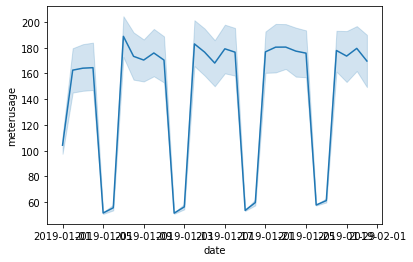

In [45]:
#Getting better knowledge of the meterusage. 
ax = sns.lineplot(x = "date", y="meterusage", data=data)

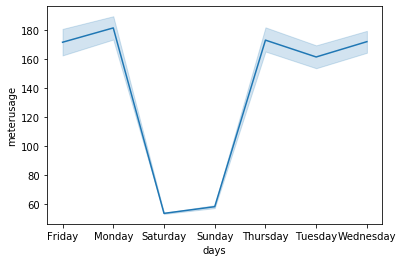

In [43]:
#Getting better knowledge of the daily meterusage. 
#The plot shows that the energy usage are always high during the weekdays and low in weekends.
ax = sns.lineplot(x = "days", y="meterusage", data=data)

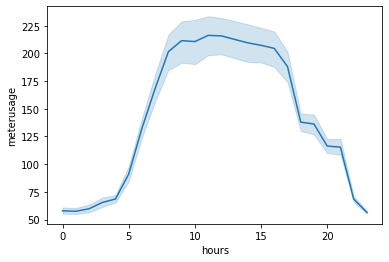

In [46]:
#Getting better knowledge of the hourly meterusage. 
#The plot shows that the energy usage are always high during the work hour from 8am till 6pm.
ax = sns.lineplot(x = "hours", y="meterusage", data=data)

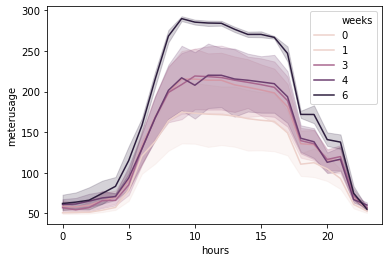

In [47]:
#The meterusage consumption is also high in the week 6
ax = sns.lineplot(x = "hours", y="meterusage", hue="weeks", data=data)

In [ ]:
#------------------------------------Data Preprocessing for Forecasting.------------------------------------#

In [49]:
"""Forecasting the meterusage and testing the last 500"""
training_data = data.iloc[:,0:1]

training_data = training_data[:-500]
print('Training dataset shape', training_data.shape)


test_data = data.tail(500)

print('Test data')
display(test_data.head())

print('Test data shape')
display(test_data.shape)

Training dataset shape (2444, 1)
Test data


,meterusage,hours,days,weeks,date
time,,,,,
14:15:00,59.23,14,Saturday,4,2019-01-26
14:30:00,59.85,14,Saturday,4,2019-01-26
14:45:00,59.15,14,Saturday,4,2019-01-26
15:00:00,59.42,15,Saturday,4,2019-01-26
15:15:00,59.31,15,Saturday,4,2019-01-26


Test data shape


(500, 5)

In [50]:
"""Scaling the data for proper preprocessing"""

training_data = training_data.values
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(training_data)

In [52]:
x_train = []
y_train = []

#the range should be 500 values till end

for i in range(500, train.shape[0]):
    """x_train 0-499"""
    x_train.append(train[i-500:i])
    
    """y data would be 500th value based on the past 500 values"""
    y_train.append(train[i])
    
"""we now convert the generated x_train and y_train into numpy array"""

x_train = np.array(x_train)
y_train = np.array(y_train)

print('Training Feature shape')
display(x_train.shape)


print('Training label shape')
display(y_train.shape)

Training Feature shape


(1944, 500, 1)

Training label shape


(1944, 1)

In [71]:
"""Shape should be number of datapaoint, steps,1"""
#Convert into rd dimension
x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1],1))
print('Shape for forecasting')
display(x_train.shape)

Shape for forecasting


(1944, 500, 1)

In [81]:
new_df = pd.concat((data[['meterusage']], test_data[['meterusage']]),axis=0)
print('New full data')
display(new_df.head())

New full data


,meterusage
time,
00:15:00,55.09
00:30:00,54.64
00:45:00,55.18
01:00:00,56.03
01:15:00,55.77


In [ ]:
test_df = new_df[len(new_df) - len(test_data) -500:].values
print('New testing data shape')
display(test_df.shape)

In [83]:
test_df = new_df[len(new_df) - len(test_data) -500:].values
 #needed to be reshaped
test_df = test_df.reshape(-1,1)

#Normalise 

test_df = sc.transform(test_df)

x_test = []

for i in range(500, 1000):
    x_test.append(test_df[i-500:i])
    
#convert into np

x_test = np.array(x_test)

#reshape 

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print('Testing Data')
display(x_test.shape)

Testing Data


(500, 500, 1)

In [72]:
#------------------------------------Training the LSTM.------------------------------------#

In [78]:
def forecasting_lstm():
    regressor = Sequential()

#Adding the first LSTM layer and some dropout reqularisation

    regressor.add(LSTM(units =50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    regressor.add(Dropout(0.1))

#Adding the second LSTM layer and some dropout reqularisation

    regressor.add(LSTM(units =50, return_sequences = True))
    regressor.add(Dropout(0.1))

#Adding the third LSTM layer and some dropout reqularisation

    regressor.add(LSTM(units =30, return_sequences = True))
    regressor.add(Dropout(0.1))

#Adding the fourth LSTM layer and some dropout reqularisation

    regressor.add(LSTM(units =10))
    regressor.add(Dropout(0.1))

#Adding the output layer

    regressor.add(Dense(units =1))

#compliling the RNN
    regressor.compile(optimizer = 'adam', loss='mean_squared_error')
    return regressor

In [79]:
model = forecasting_lstm()

In [80]:
forecasting = model.fit(x_train,y_train, epochs= 50, batch_size =32)

Train on 1944 samples
Epoch 1/50
1944/1944 [==============================] - 98s 50ms/sample - loss: 0.0700
Epoch 2/50
1944/1944 [==============================] - 99s 51ms/sample - loss: 0.0195
Epoch 3/50
1944/1944 [==============================] - 92s 47ms/sample - loss: 0.0160
Epoch 4/50
1944/1944 [==============================] - 88s 45ms/sample - loss: 0.0143
Epoch 5/50
1944/1944 [==============================] - 91s 47ms/sample - loss: 0.0132
Epoch 6/50
1944/1944 [==============================] - 105s 54ms/sample - loss: 0.0121
Epoch 7/50
1944/1944 [==============================] - 86s 44ms/sample - loss: 0.0106
Epoch 8/50
1944/1944 [==============================] - 103s 53ms/sample - loss: 0.0107
Epoch 9/50
1944/1944 [==============================] - 113s 58ms/sample - loss: 0.0104
Epoch 10/50
1944/1944 [==============================] - 87s 45ms/sample - loss: 0.0092
Epoch 11/50
1944/1944 [==============================] - 93s 48ms/sample - loss: 0.0091
Epoch 12/50
1944

In [ ]:
#------------------------------------Testing the Model.------------------------------------#

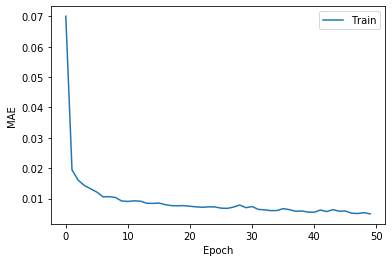

In [90]:
plt.plot(forecasting.history['loss'], label='Train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

In [86]:
"""Making the prediction"""
predicted = model.predict(x_test)

In [91]:
#Perform inverse transform to get the normal data back
predicted = sc.inverse_transform(predicted)

In [92]:
real_meterusage = test_data['meterusage'].to_list()
dates = test_data.index.to_list()

In [93]:
pred_df = pd.DataFrame(data ={
    'Date':dates,
    'real_meterusage':real_meterusage,
    'predicted': [x[0] for x in predicted]
})

Plot between the real (blue) and predicted values (green) 


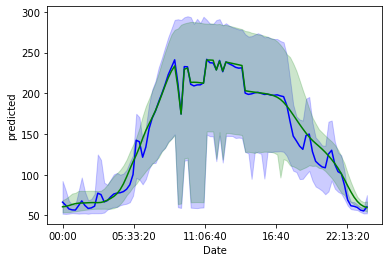

In [104]:
ax = sns.lineplot(x = "Date", y="real_meterusage", color='blue',  markers=True, dashes=False, data=pred_df)
ax = sns.lineplot(x = "Date", y="predicted", color='green', markers=True, dashes=False, data=pred_df)
print('Plot between the real (blue) and predicted values (green) ')

In [101]:
"""Checking the coefficient of determination"""
print('Predictive Accuracy')
R2 = r2_score(real_meterusage, predicted)
print('The predictive coefficient of determination is .................................................')
display(R2)

"""Checking the mean absolute error"""
MAE = mean_absolute_error(real_meterusage, predicted)
print('The predictive mean absolute error is .................................................')
display(MAE)


"""Checking the mean squared error"""
MSE = mean_squared_error(real_meterusage, predicted)
print('The predictive mean squared error is .................................................')
display(MSE)


Predictive Accuracy
The predictive coefficient of determination is .................................................


0.9653582576503671

The predictive mean absolute error is .................................................


10.68316623779297

The predictive mean squared error is .................................................


291.14476352750245